# Getting the data into Google Colab

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files 
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rayindraneel","key":"9fc535c245d5d196cc56a4c2b8b0d66a"}'}

In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
 ! kaggle datasets list

ref                                                          title                                           size  lastUpdated          downloadCount  
-----------------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  
szymonjanowski/internet-articles-data-with-users-engagement  Internet news data with readers engagement       3MB  2020-11-21 17:09:57           2237  
sakshigoyal7/credit-card-customers                           Credit Card customers                          379KB  2020-11-19 07:38:44           8697  
imoore/2020-us-general-election-turnout-rates                2020 US General Election Turnout rates           4KB  2020-11-26 00:21:15           2826  
afrniomelo/3w-dataset                                        3W Dataset - Undesirable events in oil wells   658MB  2020-11-21 21:22:49            441  
patrickb1912/ipl-complete-dataset-20082020                   IPL Complete Dataset (2008-

In [ ]:
! kaggle datasets download -d vbookshelf/respiratory-sound-database

100% 3.69G/3.69G [00:45<00:00, 49.4MB/s]
100% 3.69G/3.69G [00:45<00:00, 86.6MB/s]


In [ ]:
# Load various imports 
from datetime import datetime
import os
from os import listdir
from os.path import isfile, join

import librosa
import librosa.display

import numpy as np
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
! mkdir input
! unzip respiratory-sound-database.zip -d input

Archive:  respiratory-sound-database.zip
  inflating: input/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Al_sc_Meditron.txt  
  inflating: input/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Al_sc_Meditron.wav  
  inflating: input/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Pr_sc_Meditron.txt  
  inflating: input/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Pr_sc_Meditron.wav  
  inflating: input/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/102_1b1_Ar_sc_Meditron.txt  
  inflating: input/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/102_1b1_Ar_sc_Meditron.wav  
  inflating: input/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/103_2b2_Ar_mc_LittC2SE.txt  
  inflating: input/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/103_2b2_Ar_m

In [ ]:
os.listdir('input')

['demographic_info.txt',
 'respiratory_sound_database',
 'Respiratory_Sound_Database']

In [ ]:
os.listdir('input/respiratory_sound_database/Respiratory_Sound_Database')

['filename_format.txt',
 'patient_diagnosis.csv',
 'audio_and_txt_files',
 'filename_differences.txt']

#Listen to an Audio File

In [ ]:
! pip install pydub

Playing an audio file.

In [ ]:
from pydub import AudioSegment
import IPython

# We will listen to this file:
# 213_1p5_Pr_mc_AKGC417L.wav

audio_file = '213_1p5_Pr_mc_AKGC417L.wav'

path = \
'input/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files/' + audio_file

IPython.display.Audio(path)

In [ ]:
mypath = "input/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files/"
filenames = [f for f in listdir(mypath) if (isfile(join(mypath, f)) and f.endswith('.wav'))] 

In [ ]:
p_id_in_file = [] # patient IDs corresponding to each file
for name in filenames:
    p_id_in_file.append(int(name[:3]))

p_id_in_file = np.array(p_id_in_file)

In [ ]:
max_pad_len = 862 # to make the length of all MFCC equal

def extract_features(file_name):
    """
    This function takes in the path for an audio file as a string, loads it, and returns the MFCC
    of the audio"""
   
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast', duration=20) 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None 
     
    return mfccs

In [ ]:
filepaths = [join(mypath, f) for f in filenames] # full paths of files

In [ ]:
p_diag = pd.read_csv("input/respiratory_sound_database/Respiratory_Sound_Database/patient_diagnosis.csv",header=None) # patient diagnosis file

In [ ]:
labels = np.array([p_diag[p_diag[0] == x][1].values[0] for x in p_id_in_file]) # labels for audio files

In [ ]:
  features = [] 

# Iterate through each sound file and extract the features
for file_name in filepaths:
    data = extract_features(file_name)
    features.append(data)

print('Finished feature extraction from ', len(features), ' files')
features = np.array(features)

Finished feature extraction from  920  files


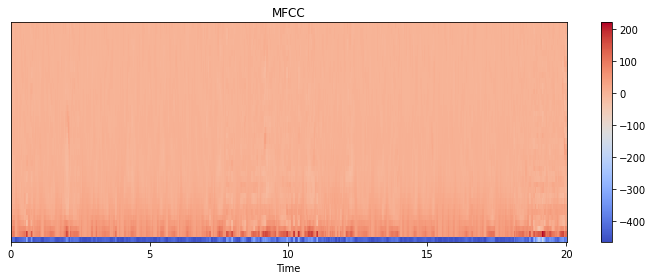

In [ ]:
# plot an MFCC
plt.figure(figsize=(10, 4))
librosa.display.specshow(features[7], x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

In [ ]:
features = np.array(features) # convert to numpy array

In [ ]:
# delete the very rare diseases
features1 = np.delete(features, np.where((labels == 'Asthma') | (labels == 'LRTI'))[0], axis=0) 

labels1 = np.delete(labels, np.where((labels == 'Asthma') | (labels == 'LRTI'))[0], axis=0)

In [ ]:
# print class counts
unique_elements, counts_elements = np.unique(labels1, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[['Bronchiectasis' 'Bronchiolitis' 'COPD' 'Healthy' 'Pneumonia' 'URTI']
 ['16' '13' '793' '35' '37' '23']]


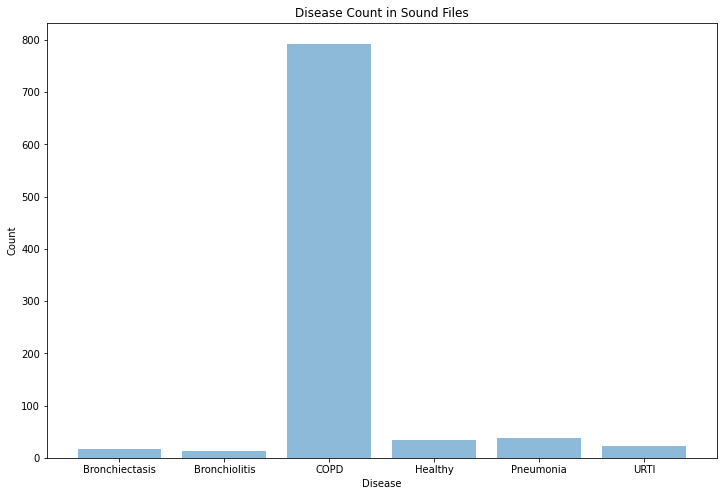

In [ ]:
# plot class counts
y_pos = np.arange(len(unique_elements))
plt.figure(figsize=(12,8))
plt.bar(unique_elements, counts_elements, align='center', alpha=0.5)
plt.xticks(y_pos, unique_elements)
plt.ylabel('Count')
plt.xlabel('Disease')
plt.title('Disease Count in Sound Files')
plt.show()

In [ ]:
# One-hot encode labels
le = LabelEncoder()
i_labels = le.fit_transform(labels1)
oh_labels = to_categorical(i_labels) 

In [ ]:
print(oh_labels.shape)

(917, 6)


In [ ]:
# add channel dimension for CNN
features1 = np.reshape(features1, (*features1.shape,1)) 

In [ ]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(features1, oh_labels, stratify=oh_labels, 
                                                    test_size=0.2, random_state = 42)

In [ ]:
num_rows = 40
num_columns = 862
num_channels = 1

#num_labels = oh_labels.shape[1]
num_labels = oh_labels.shape[1]
filter_size = 2

# Construct model 
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=filter_size,
                 input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax')) 

In [ ]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam') 

In [ ]:
# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 39, 861, 16)       80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 19, 430, 16)       0         
_________________________________________________________________
dropout (Dropout)            (None, 19, 430, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 429, 32)       2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 214, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 214, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 213, 64)        8

In [ ]:
# train model
num_epochs = 25
num_batch_size = 128

callbacks = [
    ModelCheckpoint(
        filepath='mymodel2_{epoch:02d}.h5',
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_accuracy` score has improved.
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1)
]
start = datetime.now()

history = model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs,
          validation_data=(x_test, y_test), callbacks=callbacks, verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/25
6/6 [==============================] - ETA: 0s - loss: 5.8885 - accuracy: 0.6085
Epoch 00001: val_accuracy improved from -inf to 0.86413, saving model to mymodel2_01.h5
6/6 [==============================] - 14s 2s/step - loss: 5.8885 - accuracy: 0.6085 - val_loss: 2.0856 - val_accuracy: 0.8641
Epoch 2/25
6/6 [==============================] - ETA: 0s - loss: 4.8406 - accuracy: 0.8472
Epoch 00002: val_accuracy did not improve from 0.86413
6/6 [==============================] - 13s 2s/step - loss: 4.8406 - accuracy: 0.8472 - val_loss: 1.9640 - val_accuracy: 0.8424
Epoch 3/25
6/6 [==============================] - ETA: 0s - loss: 3.5447 - accuracy: 0.8404
Epoch 00003: val_accuracy did not improve from 0.86413
6/6 [==============================] - 13s 2s/step - loss: 3.5447 - accuracy: 0.8404 - val_loss: 1.8442 - val_accuracy: 0.2826
Epoch 4/25
6/6 [==============================] - ETA: 0s - loss: 2.3906 - accuracy: 0.8117
Epoch 00004: val_accuracy did not improve from 0.8641

In [ ]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.8567530512809753
Testing Accuracy:  0.8369565010070801


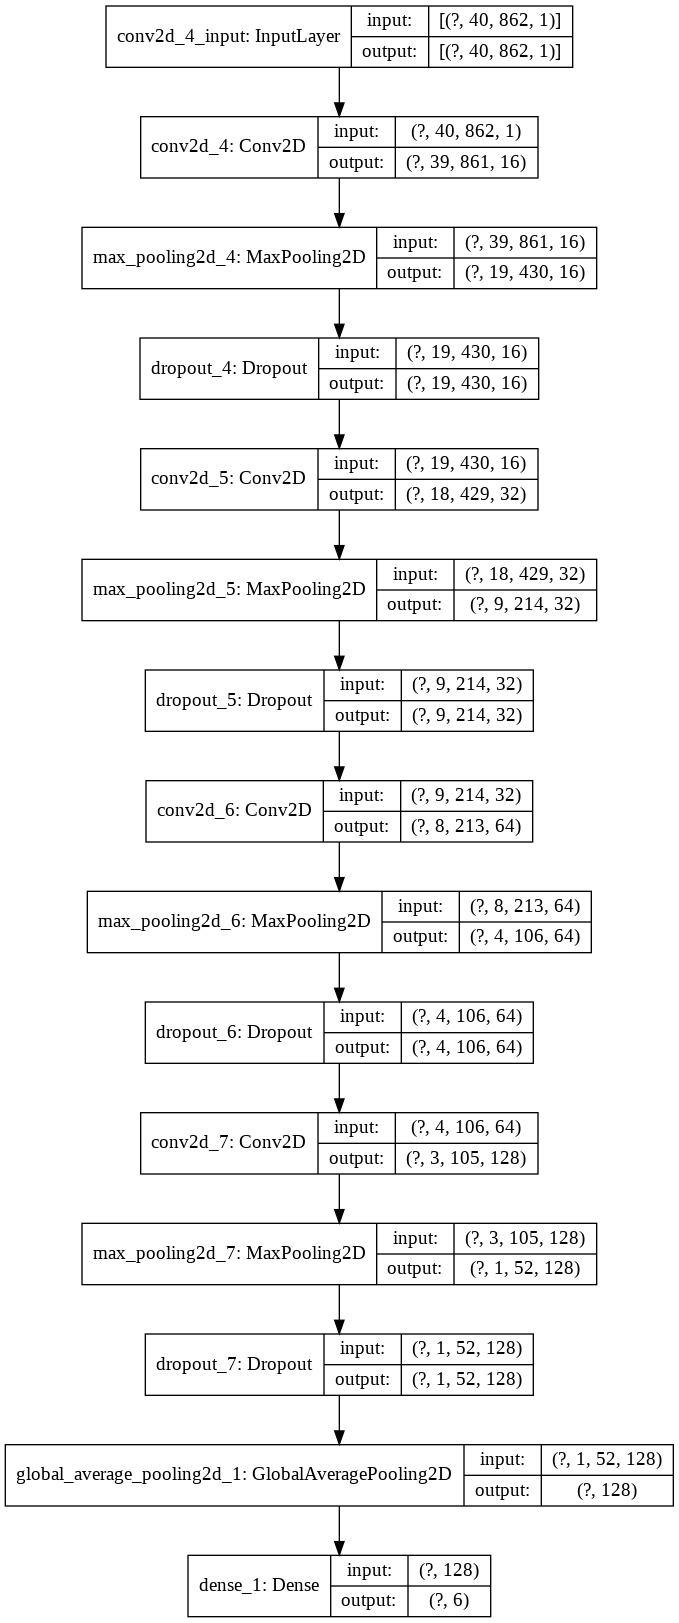

In [ ]:
import keras
keras.utils.plot_model(model, "model.png", show_shapes=True)

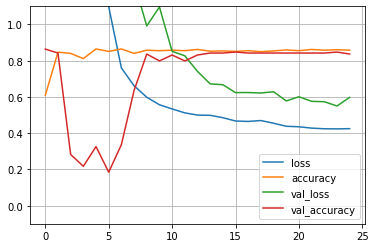

In [ ]:
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.gca().set_ylim(-0.1,1.1)
plt.show()

                precision    recall  f1-score   support

Bronchiectasis       0.17      0.33      0.22         3
 Bronchiolitis       0.00      0.00      0.00         3
          COPD       0.91      0.94      0.93       159
       Healthy       0.00      0.00      0.00         7
     Pneumonia       0.33      0.29      0.31         7
          URTI       0.17      0.20      0.18         5

      accuracy                           0.84       184
     macro avg       0.26      0.29      0.27       184
  weighted avg       0.81      0.84      0.82       184



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


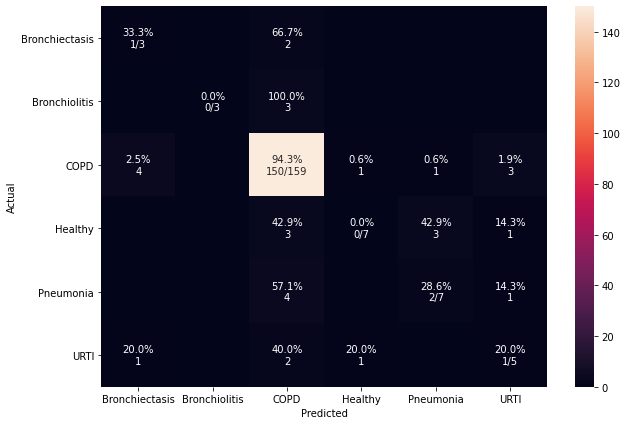

In [ ]:
import seaborn as sn

matrix_index = ["Bronchiectasis", "Bronchiolitis", "COPD", "Healthy", "Pneumonia", "URTI"]

preds = model.predict(x_test)
classpreds = np.argmax(preds, axis=1) # predicted classes 
y_testclass = np.argmax(y_test, axis=1) # true classes

cm = confusion_matrix(y_testclass, classpreds)
print(classification_report(y_testclass, classpreds, target_names=matrix_index))

# Get percentage value for each element of the matrix
cm_sum = np.sum(cm, axis=1, keepdims=True)
cm_perc = cm / cm_sum.astype(float) * 100
annot = np.empty_like(cm).astype(str)
nrows, ncols = cm.shape
for i in range(nrows):
    for j in range(ncols):
        c = cm[i, j]
        p = cm_perc[i, j]
        if i == j:
            s = cm_sum[i]
            annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
        elif c == 0:
            annot[i, j] = ''
        else:
            annot[i, j] = '%.1f%%\n%d' % (p, c)


# Display confusion matrix 
df_cm = pd.DataFrame(cm, index = matrix_index, columns = matrix_index)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
fig, ax = plt.subplots(figsize=(10,7))
sn.heatmap(df_cm, annot=annot, fmt='')

### Noise Injection 

In [ ]:
#add noise to data
noise_factor = 0.005
noisy_data = []
def add_noise(file_path):
  input_length = 16000
  data = librosa.core.load(file_path)[0] #, sr=16000
  if len(data)>input_length:
      data = data[:input_length]
  else:
      data =  np.pad(data, (0, max(0, input_length - len(data))), "constant")
  noise = np.random.randn(len(data))
  data_wn = data + noise_factor * noise
  return data_wn

In [ ]:
max_pad_len = 862 # to make the length of all MFCC equal

def extract_features_for_augmented_data(data):
      mfccs_n = librosa.feature.mfcc(y=data, sr=16000, n_mfcc=40)
      pad_width = max_pad_len - mfccs_n.shape[1]
      mfccs_n = np.pad(mfccs_n, pad_width=((0, 0), (0, pad_width)), mode='constant')  
      return mfccs_n

In [ ]:
noisylabels = np.array([p_diag[p_diag[0] == x][1].values[0] for x in p_id_in_file]) # labels for noisy audio files

In [ ]:
#ADD noise and extract features
noisy_features = [] 

# Iterate through each sound file and extract the features
for file_name in filepaths:
  noisy_data = add_noise(file_name)
  fe = extract_features_for_augmented_data(noisy_data)
  noisy_features.append(fe)

print('Finished feature extraction from ', len(noisy_features), ' files')
noisy_features = np.array(noisy_features)


Finished feature extraction from  920  files


In [ ]:
print(noisy_features.shape)

(920, 40, 862)


In [ ]:
# delete the very rare diseases and COPD
noisyfeatures1 = np.delete(features, np.where((labels == 'Asthma') | (labels == 'LRTI') | (labels == 'COPD'))[0], axis=0) 

noisylabels1 = np.delete(labels, np.where((labels == 'Asthma') | (labels == 'LRTI') | (labels == 'COPD'))[0], axis=0)

# print class counts
unique_elements, counts_elements = np.unique(noisylabels1, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[['Bronchiectasis' 'Bronchiolitis' 'Healthy' 'Pneumonia' 'URTI']
 ['16' '13' '35' '37' '23']]


In [ ]:
#combine inital data and augmented data
print(features1.shape)
print(noisyfeatures1.shape)
#final_features = np.concatenate([features1,noisyfeatures1],-1)
final_features = np.append(features1, noisyfeatures1, axis=0)
final_labels = np.append(labels1, noisylabels1, axis=0)
print(final_features.shape)
print(final_labels.shape)

(917, 40, 862)
(124, 40, 862)
(1041, 40, 862)
(1041,)


In [ ]:
unique_elements, counts_elements = np.unique(final_labels, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[['Bronchiectasis' 'Bronchiolitis' 'COPD' 'Healthy' 'Pneumonia' 'URTI']
 ['32' '26' '793' '70' '74' '46']]


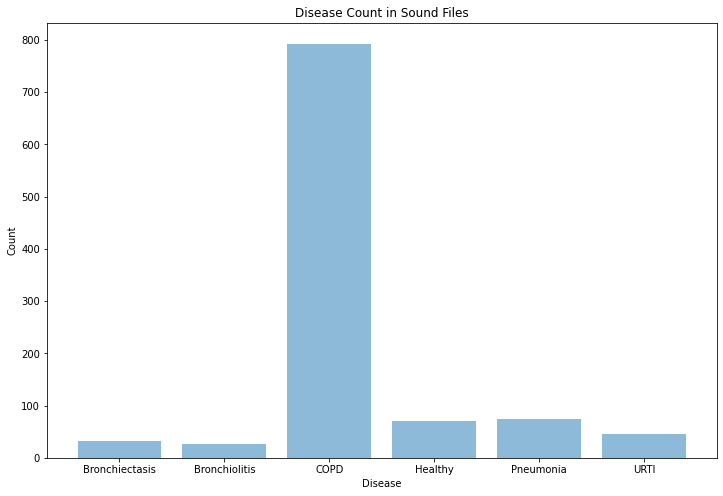

In [ ]:
# plot class counts
y_pos = np.arange(len(unique_elements))
plt.figure(figsize=(12,8))
plt.bar(unique_elements, counts_elements, align='center', alpha=0.5)
plt.xticks(y_pos, unique_elements)
plt.ylabel('Count')
plt.xlabel('Disease')
plt.title('Disease Count in Sound Files')
plt.show()

In [ ]:
# One-hot encode labels
le = LabelEncoder()
finali_labels = le.fit_transform(final_labels)
finaloh_labels = to_categorical(finali_labels) 

In [ ]:
# add channel dimension for CNN
finalfeatures1 = np.reshape(final_features, (*final_features.shape,1)) 

In [ ]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(finalfeatures1, finaloh_labels, stratify=finaloh_labels, 
                                                    test_size=0.2, random_state = 42)

In [ ]:
print(y_train.shape)

(832, 6)


In [ ]:
print(y_test.shape)

(209, 6)


In [ ]:
# train model
num_epochs = 25
num_batch_size = 128

callbacks = [
    ModelCheckpoint(
        filepath='mymodel2_{epoch:02d}.h5',
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_accuracy` score has improved.
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1)
]
start = datetime.now()

history = model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs,
          validation_data=(x_test, y_test), callbacks=callbacks, verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/25
7/7 [==============================] - ETA: 0s - loss: 0.4217 - accuracy: 0.8353
Epoch 00001: val_accuracy improved from -inf to 0.77512, saving model to mymodel2_01.h5
7/7 [==============================] - 16s 2s/step - loss: 0.4217 - accuracy: 0.8353 - val_loss: 0.5981 - val_accuracy: 0.7751
Epoch 2/25
7/7 [==============================] - ETA: 0s - loss: 0.4140 - accuracy: 0.8401
Epoch 00002: val_accuracy did not improve from 0.77512
7/7 [==============================] - 16s 2s/step - loss: 0.4140 - accuracy: 0.8401 - val_loss: 0.5930 - val_accuracy: 0.7751
Epoch 3/25
7/7 [==============================] - ETA: 0s - loss: 0.4255 - accuracy: 0.8365
Epoch 00003: val_accuracy did not improve from 0.77512
7/7 [==============================] - 16s 2s/step - loss: 0.4255 - accuracy: 0.8365 - val_loss: 0.6200 - val_accuracy: 0.7703
Epoch 4/25
7/7 [==============================] - ETA: 0s - loss: 0.4195 - accuracy: 0.8365
Epoch 00004: val_accuracy improved from 0.77512 to 0.

In [ ]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.8497596383094788
Testing Accuracy:  0.779904305934906


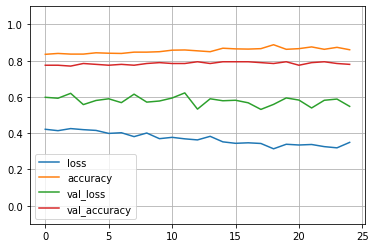

In [ ]:
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.gca().set_ylim(-0.1,1.1)
plt.show()

In [ ]:
predict_class = np.argmax(model.predict(x_test), axis=1)

                precision    recall  f1-score   support

Bronchiectasis       0.20      0.14      0.17         7
 Bronchiolitis       0.14      0.20      0.17         5
          COPD       0.83      0.98      0.90       159
       Healthy       0.57      0.29      0.38        14
     Pneumonia       0.00      0.00      0.00        15
          URTI       1.00      0.11      0.20         9

      accuracy                           0.78       209
     macro avg       0.46      0.29      0.30       209
  weighted avg       0.72      0.78      0.73       209



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


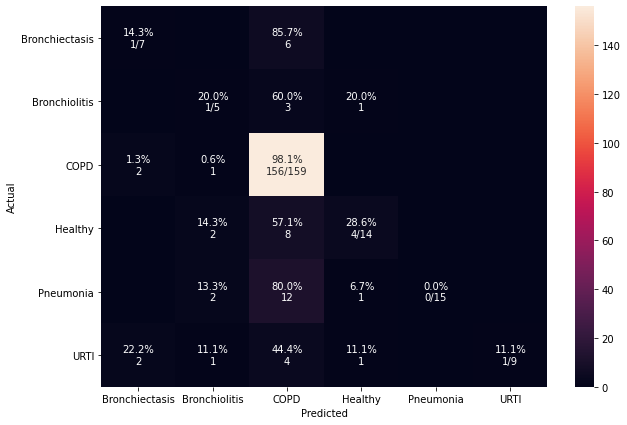

In [ ]:
matrix_index = ["Bronchiectasis", "Bronchiolitis", "COPD", "Healthy", "Pneumonia", "URTI"]

preds = model.predict(x_test)
classpreds = np.argmax(preds, axis=1) # predicted classes 
y_testclass = np.argmax(y_test, axis=1) # true classes

cm = confusion_matrix(y_testclass, classpreds)
print(classification_report(y_testclass, classpreds, target_names=matrix_index))

# Get percentage value for each element of the matrix
cm_sum = np.sum(cm, axis=1, keepdims=True)
cm_perc = cm / cm_sum.astype(float) * 100
annot = np.empty_like(cm).astype(str)
nrows, ncols = cm.shape
for i in range(nrows):
    for j in range(ncols):
        c = cm[i, j]
        p = cm_perc[i, j]
        if i == j:
            s = cm_sum[i]
            annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
        elif c == 0:
            annot[i, j] = ''
        else:
            annot[i, j] = '%.1f%%\n%d' % (p, c)


# Display confusion matrix 
df_cm = pd.DataFrame(cm, index = matrix_index, columns = matrix_index)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
fig, ax = plt.subplots(figsize=(10,7))
sn.heatmap(df_cm, annot=annot, fmt='')